# Toliman Model Fitting

---

## Walk

- Test shift precision for sub pixel shifts based on photon noise limits
    - Fit possion noisy Zemax PSFs with noiseless zemax PSFs at different noise levels 

In [1]:
import numpy as np
import json
from scipy import ndimage
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from tqdm.auto import tqdm
from scipy.optimize import least_squares, minimize

from lib.formatter import *
from lib.conversions import *
from lib.detector_modelling import *
from lib.ZMX_model_fitting import *
from lib.synphot import *

# tqdm spacing workaround
from IPython.core.display import HTML
HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
</style>
""")

In [2]:
# Optical Architecture
sim_vals = {
    # Optical Architecture
    "aperture": 0.1, # m
    "m2_obsc": 0.011, # m, diameter
    "focal_length": 3.635, # m
    "wavelength": 595e-9, # Central wavelength

    # CCD Architecture
    "detector_size": 200, # Reduced to only show region of interest 
    "detector_pitch": 6.5e-6,
    
    # Simulation Parameters
    "transform_size": 2**10,
    "zmx_pixel_size": 1.625e-6,
    "interp_order": 1 
}

# write
with open("simulation_values.txt", 'w') as f:
    json.dump(sim_vals, f)

In [3]:
# Load Zemax PSF
psf_zmx, psf_on_meta_data_zmx = zemax_to_array('files/on-axis_monochromatic_595.txt')

In [4]:
# Take the central region from the high res zemax image
size_ratio = sim_vals["zmx_pixel_size"]/sim_vals["detector_pitch"]
c = int(psf_zmx.shape[0]//2)
s = int((sim_vals["detector_size"]/2) /size_ratio)
zmx_im = psf_zmx[c-s:c+s, c-s:c+s]
zmx_im = zmx_im/np.sum(zmx_im)
np.save("zmx_im", zmx_im)

In [5]:
# Downsample to the detector
im_zoom = ndimage.zoom(zmx_im, size_ratio)
im = im_zoom/np.sum(im_zoom)
np.save("zmx_zoom", im)

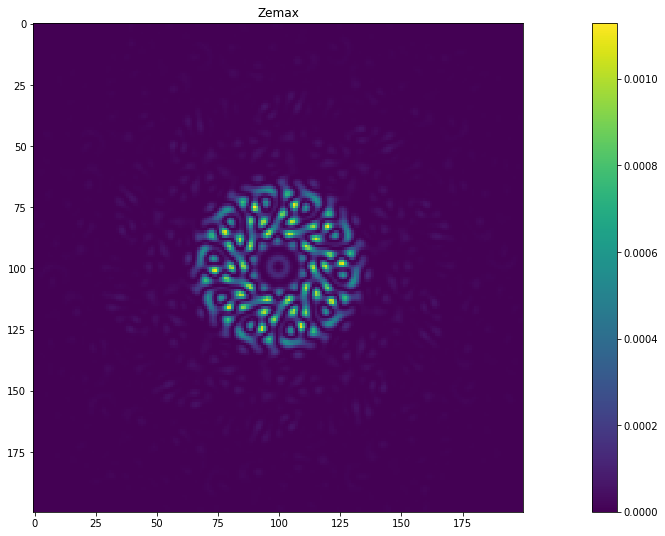

In [6]:
# Test to see everything looks normal
plt.figure(figsize=(25, 9))
plt.title("Zemax")
plt.imshow(im)
plt.colorbar()
plt.show()

---
To test consistency of fit randomise full pixel shifts then perturb at sub pixel level

change dtype to double

shift method

In [7]:
# Testing parameters
max_val = 0.1
num_shifts = 10
num_fits = 75 # Number of noisy images with the same shift to fit 
scale_factor = 1e6
tol = 1e-15
a = 9
b = 21
photon_counts = np.linspace(a, b, num=b-a+1)

In [8]:
# Generate a set of x and y values to shift the PSF by
# rs = np.linspace(0, max_val, num=num_shifts, endpoint=False).reshape(num_shifts, 1)
rs = np.random.random_sample([num_shifts, 1]) * max_val
phis = np.random.random_sample([num_shifts, 1]) * 2*np.pi
# phis = np.linspace(0, 2*np.pi, num=num_shifts, endpoint=False).reshape(num_shifts, 1)
x_in = rs*np.cos(phis)
y_in = rs*np.sin(phis)
shifts = np.concatenate((x_in, y_in), axis=1)
x_in = x_in.reshape(num_shifts)
y_in = y_in.reshape(num_shifts)

In [9]:
%%time

# Test noiseless (infinite photon count) fitting
noiseless = np.zeros([num_shifts, num_fits, 2])

for i in tqdm(range(num_shifts)):
    
    # Shift the PSF
    shifted_psf = build_model_zmx(shifts[i])
        
    # Generate a fit different noise levels
    for j in tqdm(range(num_fits), leave=False):
        
        # Create a random start point at most half a pixel away from the desired shift
        x = shifts[i][0] + np.random.ranf() * 0.25
        y = shifts[i][1] + np.random.ranf() * 0.25
        x0 = [x, y]
        
        # Apply the photon noise
        shifted_psf = shifted_psf/np.sum(shifted_psf)
        np.save("zmx_noisy", shifted_psf)
        
        # Fit the data
        out = minimize(evaluate_model_zmx, x0, method="L-BFGS-B", bounds=[(-0.5, 0.5), (-0.5, 0.5)], tol=1e-12)
        
        noiseless[i][j] = out.x - shifts[i]


CPU times: user 5min 21s, sys: 20.4 s, total: 5min 42s
Wall time: 5min 48s


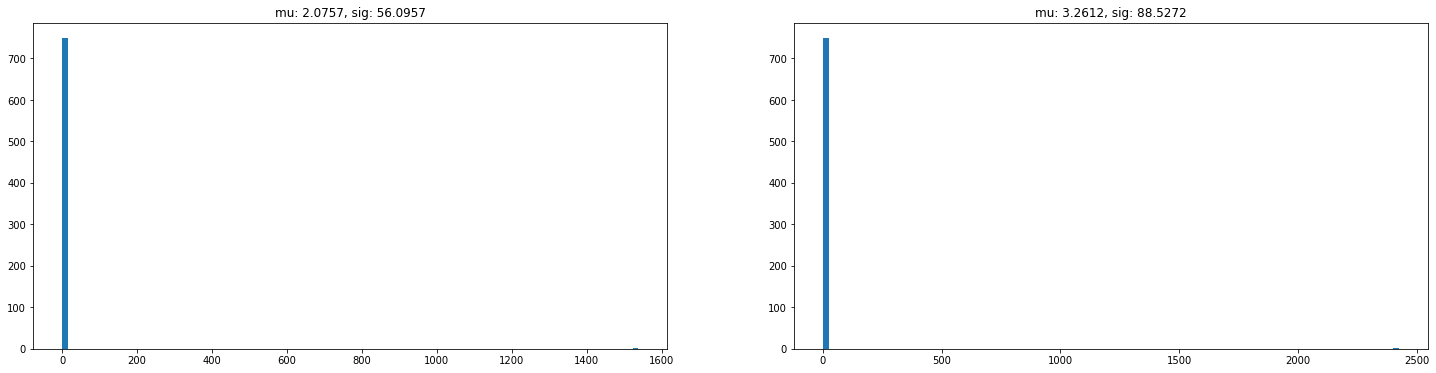

In [11]:
x = np.array(noiseless)[:,:,0].reshape(num_shifts*num_fits)
y = np.array(noiseless)[:,:,1].reshape(num_shifts*num_fits)

stdx = np.std(x)
avgx = np.average(x)
stdy = np.std(y)
avgy = np.average(y)

plt.figure(figsize=(25,6))

plt.subplot(1, 2, 1)
plt.hist(x*scale_factor, bins=100)
plt.title("mu: {:.4f}, sig: {:.4f}".format(avgx*scale_factor, stdx*scale_factor))

plt.subplot(1, 2, 2)
plt.hist(y*scale_factor, bins=100)
plt.title("mu: {:.4f}, sig: {:.4f}".format(avgy*scale_factor, stdy*scale_factor))

plt.show()

---

In [303]:
%%time

count_level = []
outs = []
fails = 0
for photon_count in tqdm(photon_counts):

    # Test noisy fitting
    noisy = np.zeros([num_shifts, num_fits, 2])

    for i in tqdm(range(num_shifts), leave=False):

        # Shift the PSF
        shifted_psf = build_model_zmx(shifts[i])

        # Generate a fit different noise levels
        for j in tqdm(range(num_fits), leave=False):

            # Create a random start point at most half a pixel away from the desired shift
            x = shifts[i][0] + np.random.ranf() * 0.25
            y = shifts[i][1] + np.random.ranf() * 0.25
            x0 = [x, y]

            # Apply the photon noise
            noisy_psf = np.random.poisson(np.abs(shifted_psf) * 10**photon_count)
            noisy_psf = noisy_psf/np.sum(noisy_psf)            
            np.save("zmx_noisy", noisy_psf)

            # Fit the data
            out = minimize(evaluate_model_zmx, x0, method="L-BFGS-B", bounds=[(-0.5, 0.5), (-0.5, 0.5)], tol=tol)
            outs.append(out)
            
            if out.success:
                noisy[i][j] = out.x - shifts[i]
            else:
                fails += 1
            
    count_level.append(noisy)

CPU times: user 1h 54min 58s, sys: 7min 49s, total: 2h 2min 48s
Wall time: 3h 45min 20s


In [305]:
print(fails)

26


In [304]:
np.save("data_{}-{}_{}_{}_{}.npy".format(a, b, num_shifts, num_fits, tol), count_level)

In [13]:
count_level = np.load("data_{}-{}_{}_{}_{}.npy".format(a, b, num_shifts, num_fits, tol))

In [15]:
xs = []
ys = []
stdxs = []
stdys = []
avgxs = []
avgys = []

for i in range(len(photon_counts)):
    xs.append(np.array(count_level[i])[:,:,0].reshape(num_shifts*num_fits))
    ys.append(np.array(count_level[i])[:,:,1].reshape(num_shifts*num_fits))

    stdxs.append(np.std(xs[i]))
    stdys.append(np.std(ys[i]))

    avgxs.append(np.average(xs[i]))
    avgys.append(np.average(ys[i]))

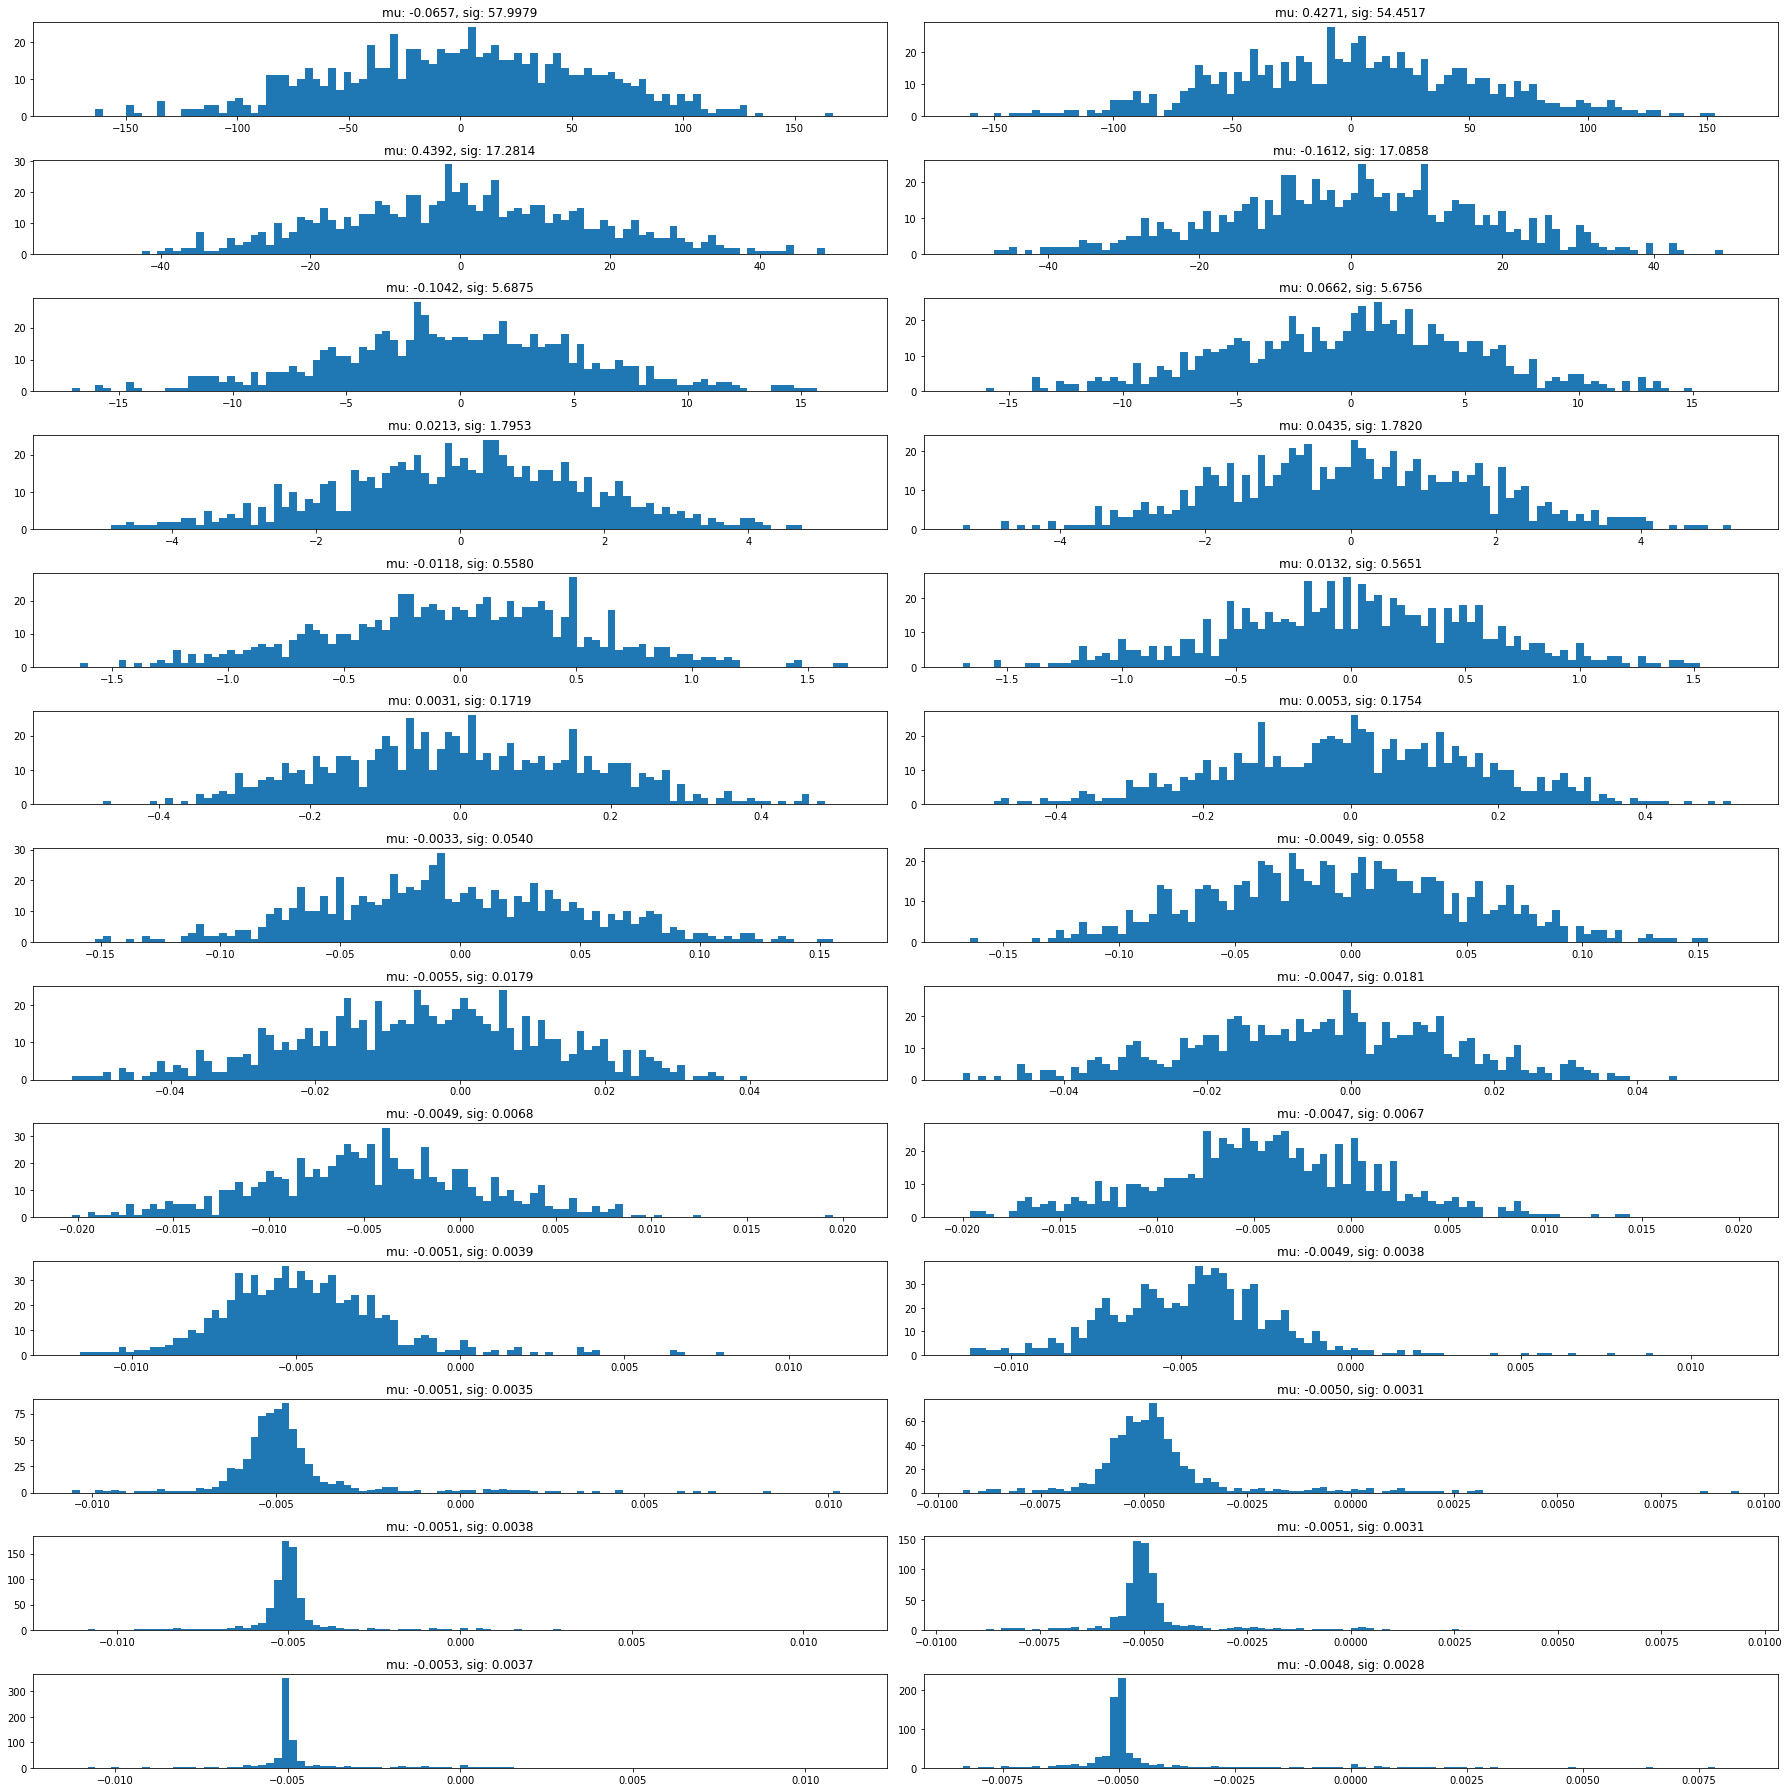

In [16]:
plt.figure(figsize=(25,25))
count = 1

for idx in range(len(photon_counts)):
    plt.subplot(len(photon_counts), 2, count)
    plt.hist(xs[idx]*scale_factor, bins=100, range=(-3*stdxs[idx]*scale_factor, 3*stdxs[idx]*scale_factor))
    plt.title("mu: {:.4f}, sig: {:.4f}".format(avgxs[idx]*scale_factor, stdxs[idx]*scale_factor))
    count += 1

    plt.subplot(len(photon_counts), 2, count)
    plt.hist(ys[idx]*scale_factor, bins=100, range=(-3*stdys[idx]*scale_factor, 3*stdys[idx]*scale_factor))
    plt.title("mu: {:.4f}, sig: {:.4f}".format(avgys[idx]*scale_factor, stdys[idx]*scale_factor))
    count += 1

plt.tight_layout()
plt.show()

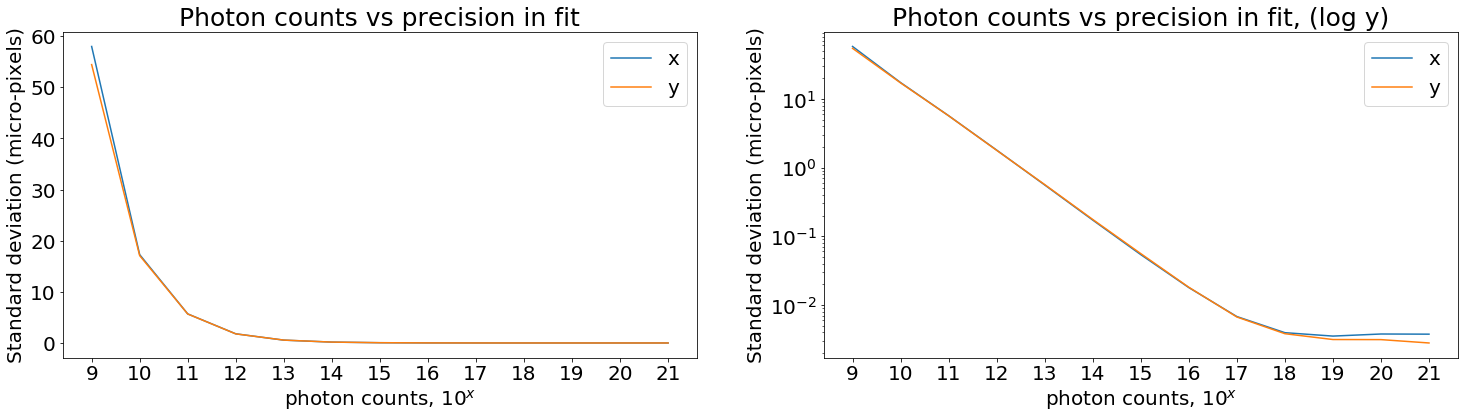

In [17]:
fig = plt.figure(figsize=(25,6))

plt.subplot(1, 2, 1)
plt.plot(np.array(stdxs)*scale_factor, label="x")
plt.plot(np.array(stdys)*scale_factor, label="y")
plt.title("Photon counts vs precision in fit", fontsize=25)
plt.xticks(np.linspace(0, len(photon_counts), len(photon_counts), endpoint=False), photon_counts.astype(int), fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("photon counts, $10^x$", fontsize=20)
plt.ylabel("Standard deviation (micro-pixels)", fontsize=20)
plt.legend(fontsize=20)

plt.subplot(1, 2, 2)
plt.semilogy(np.array(stdxs)*scale_factor, label="x")
plt.semilogy(np.array(stdys)*scale_factor, label="y")
plt.title("Photon counts vs precision in fit, (log y)", fontsize=25)
plt.xticks(np.linspace(0, len(photon_counts), len(photon_counts), endpoint=False), photon_counts.astype(int), fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("photon counts, $10^x$", fontsize=20)
plt.ylabel("Standard deviation (micro-pixels)", fontsize=20)
plt.legend(fontsize=20)

plt.savefig("data_{}-{}_{}_{}_{}.jpg".format(a, b, num_shifts, num_fits, tol))
plt.show()

In [78]:
print(len(photon_counts))

13


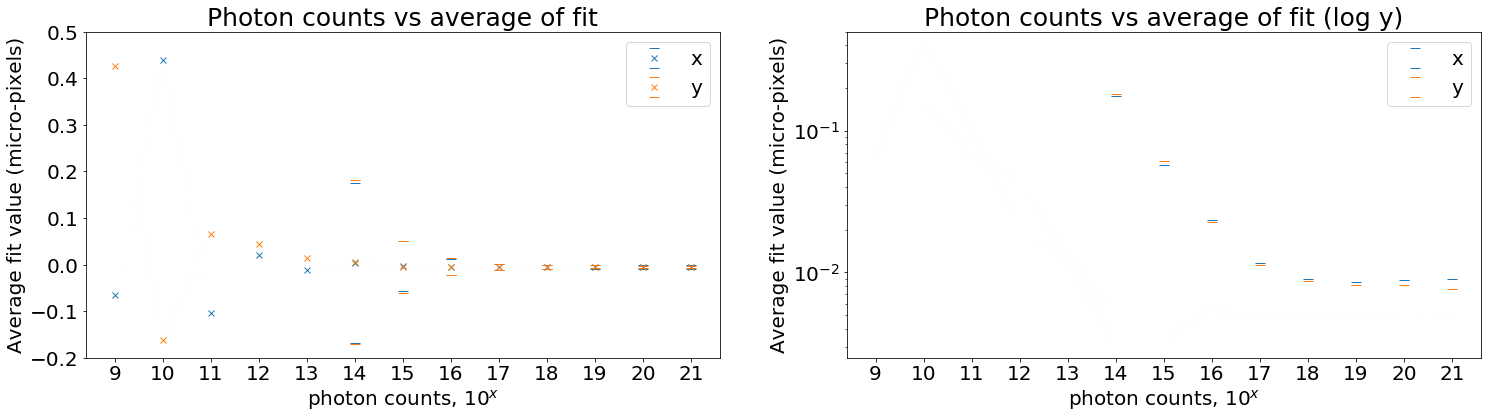

In [109]:
fig = plt.figure(figsize=(25,6))



ax = plt.subplot(1, 2, 1)
plt.errorbar(photon_counts, np.array(avgxs)*scale_factor, yerr=np.array(stdxs)*scale_factor, label="x", capsize=5, capthick=1, elinewidth=0.001, linewidth=0.001, marker='x')
plt.errorbar(photon_counts, np.array(avgys)*scale_factor, yerr=np.array(stdys)*scale_factor, label="y", capsize=5, capthick=1, elinewidth=0.001, linewidth=0.001, marker='x')
plt.title("Photon counts vs average of fit", fontsize=25)
plt.ylim([-0.2, 0.5])
ax.set_xticks(photon_counts)
ax.tick_params(labelsize=20)
plt.yticks(fontsize=20)
plt.xlabel("photon counts, $10^x$", fontsize=20)
plt.ylabel("Average fit value (micro-pixels)", fontsize=20)
plt.legend(fontsize=20)

ax = plt.subplot(1, 2, 2)
plt.errorbar(photon_counts, np.abs(np.array(avgxs))*scale_factor, yerr=np.array(stdxs)*scale_factor, label="x", capsize=5, capthick=1, elinewidth=0.001, linewidth=0.001, marker='')
plt.errorbar(photon_counts, np.abs(np.array(avgys))*scale_factor, yerr=np.array(stdys)*scale_factor, label="y", capsize=5, capthick=1, elinewidth=0.001, linewidth=0.001, marker='')
ax.set_yscale("log")
plt.title("Photon counts vs average of fit (log y)", fontsize=25)
plt.ylim([0.0025, 0.5])
ax.set_xticks(photon_counts)
ax.tick_params(labelsize=20)
plt.yticks(fontsize=20)
plt.xlabel("photon counts, $10^x$", fontsize=20)
plt.ylabel("Average fit value (micro-pixels)", fontsize=20)
plt.legend(fontsize=20)


plt.show()